# CNN basic

### Import libraries & initial set up

In [1]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Flatten, Dense, Dropout

In [4]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [7]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_size = 150
batch_size = 32

### Prepare data

In [8]:
# Path to the folder with 6 classes of images:
data_path = 'deep_mushroom'
os.chdir(data_path)

In [9]:
# Create train, valid and test folders
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')

# Add subfolders with mushrooms genuses in train, valid and test folders
for subfolder in os.listdir():
    if subfolder not in ('train','valid','test'):
        os.mkdir(f'train/{subfolder}')
        os.mkdir(f'valid/{subfolder}')
        os.mkdir(f'test/{subfolder}')

In [10]:
# Count items in each folder
for subfolder in os.listdir():

    if subfolder not in ('train','valid','test'):

        original_path = f'{subfolder}'
        original_data = os.listdir(original_path)
        n_samples = len(original_data)
        print(f'Photos in {original_path}: {n_samples}')


Photos in agaricus: 400
Photos in amanita: 610
Photos in boletus: 387
Photos in hygrocybe: 615
Photos in leccinum: 419
Photos in russula: 1157


In russula folder there are 2x more photos than in the other folders.
We would need to drop half of photos from russula folder to keep each class at similar level.

In [11]:
# Copy existing photos - randomly split to train/validation/test folders (75%/15%/10%)
for subfolder in os.listdir():

    # Making a list of all files in current subfolder:
     if subfolder not in ('train','valid','test'):

        # Making a list of all files in current subfolder:
        original_path = f'{subfolder}'
        original_data = os.listdir(original_path)

        # Train, validation and testing folders
        train_path = f'train/{subfolder}'
        valid_path = f'valid/{subfolder}'
        test_path = f'test/{subfolder}'

        # Random indices split
        # For russula genus (use 50% of available images):
        if subfolder == 'russula':
            # Number of samples in a class:
            n_samples = len(original_data)//2
            train_samples = int(n_samples * 0.75)
            valid_samples = int(n_samples * 0.9)

            idx_list = list(n for n in range(0,n_samples))
            random.shuffle(idx_list)

            # Indices lists
            train_idx = idx_list[0:train_samples]
            valid_idx = idx_list[train_samples:valid_samples]
            test_idx = idx_list[valid_samples:n_samples]

        else:
            # Number of samples in a class:
            n_samples = len(original_data)
            train_samples = int(n_samples * 0.75)
            valid_samples = int(n_samples * 0.9)

            idx_list = list(n for n in range(0,n_samples))
            random.shuffle(idx_list)

            # Indices lists
            train_idx = idx_list[0:train_samples]
            valid_idx = idx_list[train_samples:valid_samples]
            test_idx = idx_list[valid_samples:n_samples]

        # Copy image to proper folder based on index
        for image in range(n_samples):
            original_file = f'{original_path}/{original_data[image]}'
            if image in train_idx:
                new_file = f'{train_path}/{original_data[image]}'
                shutil.copyfile(original_file, new_file)
            if image in valid_idx:
                new_file = f'{valid_path}/{original_data[image]}'
                shutil.copyfile(original_file, new_file)
            if image in test_idx:
                new_file = f'{test_path}/{original_data[image]}'
                shutil.copyfile(original_file, new_file)

        print(f'Starting with {subfolder}, total number of photos copied: {n_samples}.')
        print(f'{len(train_idx)} photos copied to {train_path}.')
        print(f'{len(valid_idx)} photos copied to {valid_path}.')
        print(f'{len(test_idx)} photos copied to {test_path}.')

Starting with agaricus, total number of photos copied: 400.
300 photos copied to train/agaricus.
60 photos copied to valid/agaricus.
40 photos copied to test/agaricus.
Starting with amanita, total number of photos copied: 610.
457 photos copied to train/amanita.
92 photos copied to valid/amanita.
61 photos copied to test/amanita.
Starting with boletus, total number of photos copied: 387.
290 photos copied to train/boletus.
58 photos copied to valid/boletus.
39 photos copied to test/boletus.
Starting with hygrocybe, total number of photos copied: 615.
461 photos copied to train/hygrocybe.
92 photos copied to valid/hygrocybe.
62 photos copied to test/hygrocybe.
Starting with leccinum, total number of photos copied: 419.
314 photos copied to train/leccinum.
63 photos copied to valid/leccinum.
42 photos copied to test/leccinum.
Starting with russula, total number of photos copied: 578.
433 photos copied to train/russula.
87 photos copied to valid/russula.
58 photos copied to test/russula.


### Display images examples

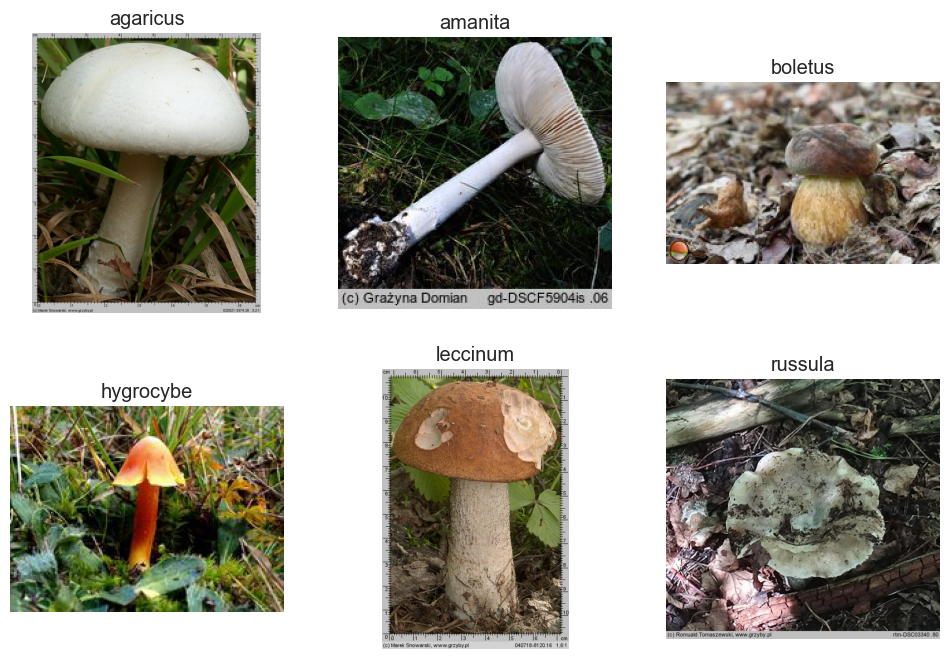

In [12]:
nrows = 2
ncols = 3

for i, subfolder in enumerate(os.listdir()):
    if i >= nrows * ncols:
        break

    image_file = os.listdir(subfolder)[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos = i + 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

### Create image datasets

In [13]:
train_generator = ImageDataGenerator(preprocessing_function = preprocess_input)\
                    .flow_from_directory(directory = 'train',
                                         target_size = (img_size, img_size),
                                         class_mode = 'categorical',
                                         batch_size = batch_size,
                                         shuffle = True)

valid_generator = ImageDataGenerator(preprocessing_function = preprocess_input)\
                    .flow_from_directory(directory = 'valid',
                                         target_size = (img_size, img_size),
                                         class_mode = 'categorical',
                                         batch_size = batch_size,
                                         shuffle = True)

test_generator = ImageDataGenerator(preprocessing_function = preprocess_input)\
                    .flow_from_directory(directory = 'test',
                                         target_size = (img_size, img_size),
                                         class_mode = 'categorical',
                                         batch_size = batch_size,
                                         shuffle = True)

Found 2255 images belonging to 6 classes.
Found 452 images belonging to 6 classes.
Found 302 images belonging to 6 classes.


### Creating model

In [17]:
# Pretrained EfficientNetB7 image classification model without final layers
print("\nSetting up the model")
model_01 = tf.keras.models.Sequential([
    Conv2D(filters = 32,
           kernel_size = 5,
           padding = 'same',
           activation = 'relu',
           input_shape = (img_size, img_size, 3)),
    BatchNormalization(),
    MaxPool2D(2),

    Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(2),

    Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(2),

    Flatten(),

    Dense(units = 64,
          activation='relu'),

    Dropout(0.1),

    Dense(units = 32,
          activation='relu'),

    Dropout(0.1),

    Dense(units = 32,
          activation='relu'),

    Dense(units = 32,
          activation='relu'),

    Dropout(0.1),

    Dense(units=6, activation='softmax'),
])
model_01.summary()


Setting up the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 batch_normalization_2 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                

In [18]:
# Compile model
model_01.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [19]:
# Train new model:
history = model_01.fit(train_generator,
                        validation_data = valid_generator,
                        epochs = 50,
                        steps_per_epoch = train_generator.n/batch_size,
                        validation_steps = valid_generator.n/batch_size,
                        verbose = 2)

Epoch 1/50
70/70 - 34s - loss: 1.8748 - accuracy: 0.2581 - val_loss: 1.8001 - val_accuracy: 0.2788 - 34s/epoch - 477ms/step
Epoch 2/50
70/70 - 23s - loss: 1.6421 - accuracy: 0.3175 - val_loss: 1.5934 - val_accuracy: 0.3296 - 23s/epoch - 332ms/step
Epoch 3/50
70/70 - 23s - loss: 1.5909 - accuracy: 0.3259 - val_loss: 1.7724 - val_accuracy: 0.2677 - 23s/epoch - 327ms/step
Epoch 4/50
70/70 - 24s - loss: 1.5225 - accuracy: 0.3530 - val_loss: 1.4786 - val_accuracy: 0.3695 - 24s/epoch - 341ms/step
Epoch 5/50
70/70 - 23s - loss: 1.4608 - accuracy: 0.3818 - val_loss: 1.4659 - val_accuracy: 0.4071 - 23s/epoch - 331ms/step
Epoch 6/50
70/70 - 24s - loss: 1.4477 - accuracy: 0.3969 - val_loss: 1.5305 - val_accuracy: 0.3673 - 24s/epoch - 338ms/step
Epoch 7/50
70/70 - 24s - loss: 1.4206 - accuracy: 0.4204 - val_loss: 1.3986 - val_accuracy: 0.4314 - 24s/epoch - 342ms/step
Epoch 8/50
70/70 - 24s - loss: 1.3634 - accuracy: 0.4381 - val_loss: 1.3727 - val_accuracy: 0.4336 - 24s/epoch - 337ms/step
Epoch 9/

### Model's accuracy

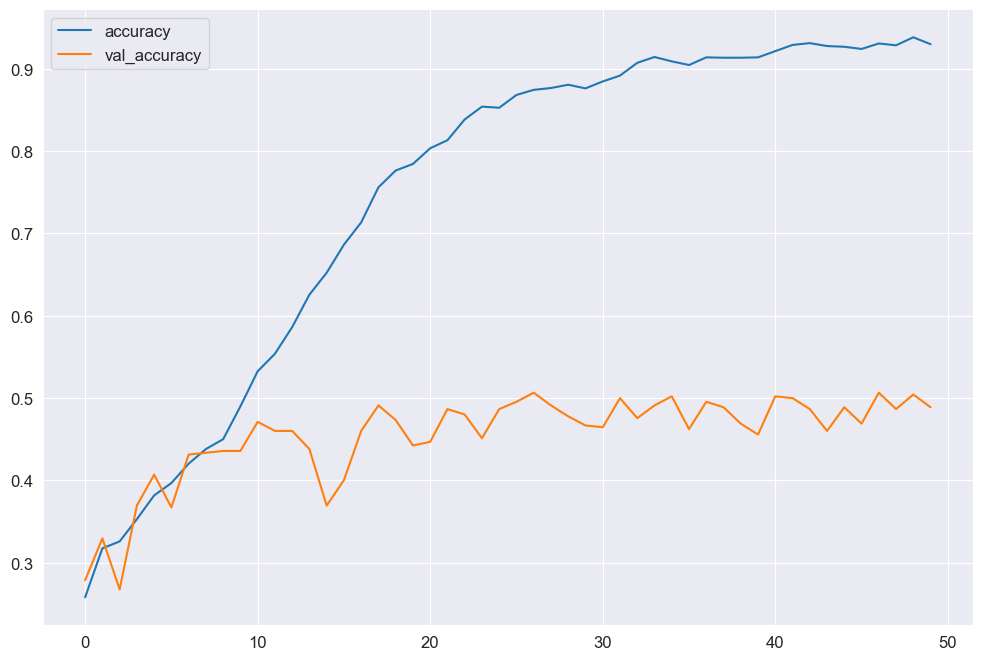

In [20]:
# Accuracy during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

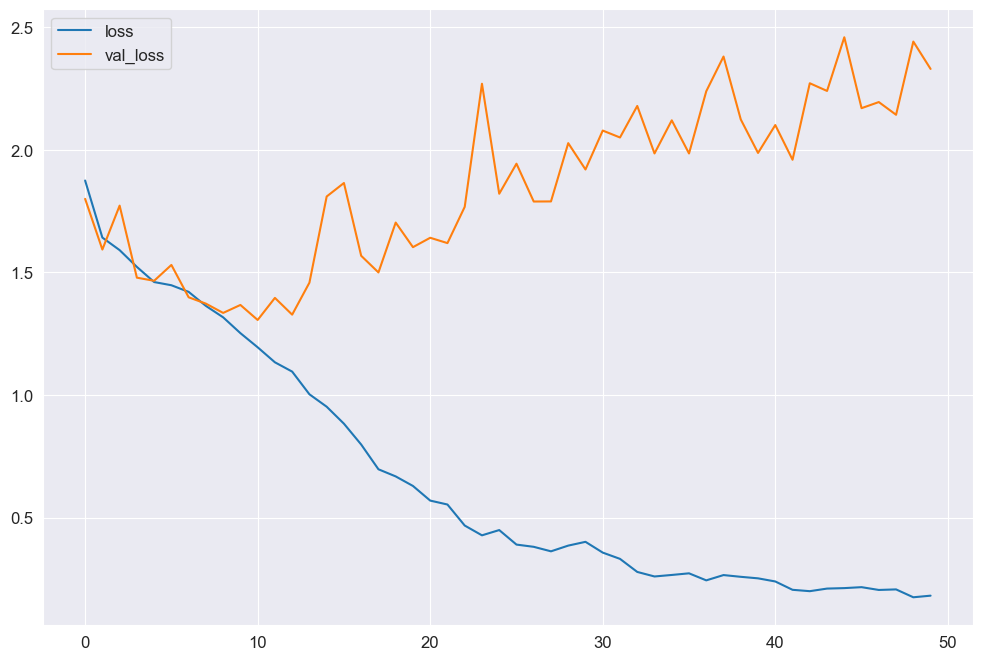

In [21]:
# Loss during training
history_frame.loc[:, ['loss', 'val_loss']].plot();

In [22]:
# Accuracy and lost for test data:
loss, accuracy = model_01.evaluate(test_generator,
                                   steps = test_generator.n/batch_size,
                                   verbose = 2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

9/9 - 3s - loss: 2.1353 - accuracy: 0.4570 - 3s/epoch - 282ms/step
Model performance on test images:
Accuracy = 0.45695364475250244
Loss = 2.135328531265259


10/10 [==============================] - 2s 142ms/step


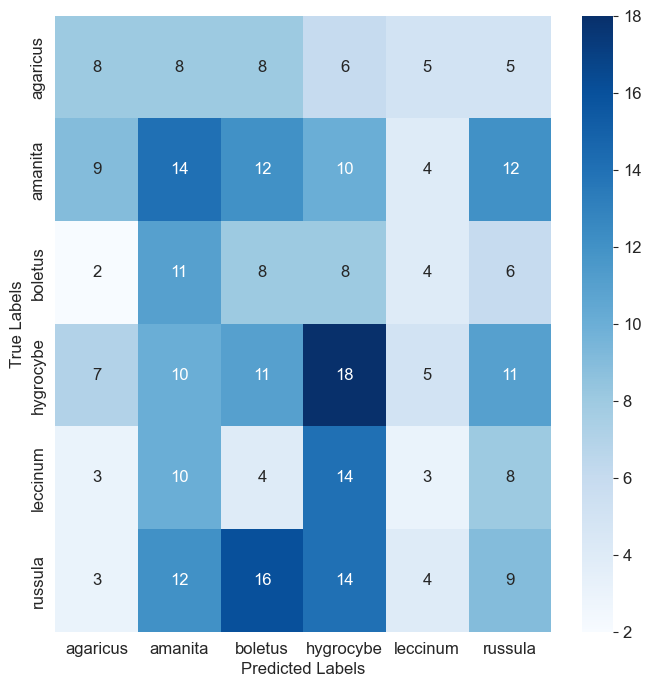

In [23]:
# Confusion matrix
# Get the predicted labels from the model
y_pred = model_01.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels from the test dataset
y_true = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels = list(range(len(class_names))))


# Plot the confusion matrix
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, cmap = plt.cm.Blues, xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()